In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import functional
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader,random_split
import numpy as np
import matplotlib.pyplot as plt

In [3]:

if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device=torch.device('cuda')
else:
    print('CUDA is not available.  Training on CPU ...')
    device=torch.device('cpu')

CUDA is available!  Training on GPU ...


In [4]:
path='../input/100-bird-species/birds/'
num_workers = 3
batch_size = 20
valid_size = 0.2
train_transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
test_transform = transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(path+'train', transform=train_transform)
test_data = datasets.ImageFolder(path+'test', transform=test_transform)
val_data = datasets.ImageFolder(path+'valid', transform=test_transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers,shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

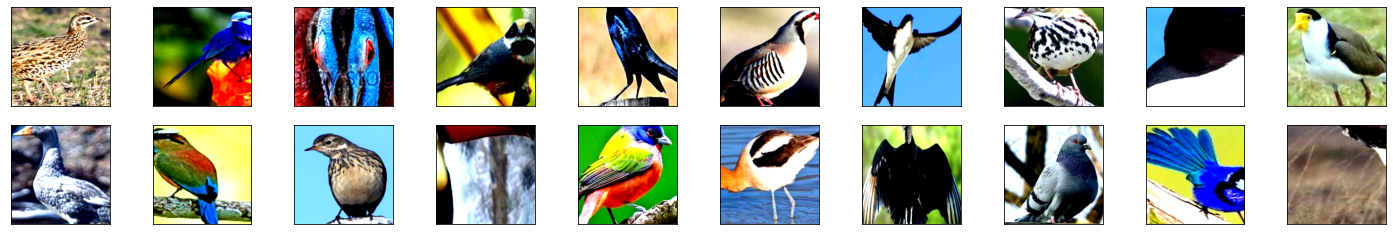

In [5]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0))) 
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    # ax.set_title(classes[labels[idx]])

In [6]:
architecture = [64 , 64 , -1 , 128 , 128 , -1 , 256 , 256, 256 , -1, 512, 512, 512 , -1 , 512 ,512, 512,-1]
class VGG(nn.Module):
   def __init__(self,in_channels=3,num_classes=275):
    super(VGG,self).__init__()
    self.in_channels = in_channels
    self.mai = self.main_architecture(architecture)
    self.fcs = nn.Sequential(nn.Linear(512*7*7,4096),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096,4096),
                            nn.ReLU(),
                            nn.Dropout(p=0.5),
                            nn.Linear(4096,num_classes))                               
   def forward(self,x):
     x = self.mai(x)
     x = x.reshape(x.shape[0], -1)
     x = self.fcs(x)
     return x 
   def main_architecture(self,architecture):
            blocks = []
            in_channels = self.in_channels
            for layer in architecture:
                      if layer != -1 : 
                        out_channels = layer
                        blocks+=[nn.Conv2d(in_channels=in_channels,out_channels = out_channels , kernel_size = (3,3) , stride =(1,1) ,padding = (1,1) ),nn.BatchNorm2d(layer),nn.ReLU()]
                        in_channels = layer 
                      elif layer == -1 :
                        blocks+=[(nn.MaxPool2d(kernel_size=(2,2),stride= (2,2)))]
            return nn.Sequential(*blocks)


In [7]:
model=VGG()
model=model.to(device)
print(model)

VGG(
  (mai): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 

In [8]:
train_on_gpu = torch.cuda.is_available()

In [9]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.75)
criterion = nn.CrossEntropyLoss()

In [10]:
n_epochs = 8 
valid_loss_min = np.Inf
train_losses, val_losses=[] ,[]
for epoch in range(1, n_epochs+1):

    
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for data, target in train_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for data, target in valid_loader:
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        output = model(data)
        loss = criterion(output, target)
        valid_loss += loss.item()*data.size(0)
    
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 5.498279 	Validation Loss: 5.132335
Validation loss decreased (inf --> 5.132335).  Saving model ...
Epoch: 2 	Training Loss: 5.212938 	Validation Loss: 4.701510
Validation loss decreased (5.132335 --> 4.701510).  Saving model ...
Epoch: 3 	Training Loss: 4.927520 	Validation Loss: 4.268186
Validation loss decreased (4.701510 --> 4.268186).  Saving model ...
Epoch: 4 	Training Loss: 4.604068 	Validation Loss: 3.719138
Validation loss decreased (4.268186 --> 3.719138).  Saving model ...
Epoch: 5 	Training Loss: 4.324896 	Validation Loss: 3.232517
Validation loss decreased (3.719138 --> 3.232517).  Saving model ...
Epoch: 6 	Training Loss: 4.062245 	Validation Loss: 2.815811
Validation loss decreased (3.232517 --> 2.815811).  Saving model ...
Epoch: 7 	Training Loss: 3.760843 	Validation Loss: 2.405512
Validation loss decreased (2.815811 --> 2.405512).  Saving model ...
Epoch: 8 	Training Loss: 3.480452 	Validation Loss: 1.983607
Validation loss decreased (2.40551